# Постановка задачи

Имеются изображения технологического процесса разлива металлических циллиндров. Есть риск нарушения технологии, когда стенки цилиндра не успевают застывать и трескаются. Не застывшый металл выливается, не образуя требуюмую заготовку. Необходимо оперативно определить лунку где произошел пролив. При этом пролив дольно редкое явление. Гораздо больше изображений можно собрать без пролива в лунке.

## Задача: построить модель (на основе автоэнкодера) определяющую состояние лунки пролив\не пролив.

title

Датесет
Данные - вырезанные изображения лунок. Ссыла на даасет

dataset
```
├── proliv  # изображения с проливами
|       ├── 000.jpg
│       ├── 001.jpg
│       │   └── ...
|
├── test  # тестовая выборка где перемешаны проливы и не_проливы
│       ├── imgs
│       │   ├── 000.jpg
│       │   ├── 001.jpg
│       │   └── ...
│       └── test_annotation.txt
|
├── train  #  обучающая выборка из не_проливов
|       ├── 000.jpg
│       ├── 001.jpg
│       └── ...
```
## План решения
1. Имплементировать или найти автоэкодер (можно для старта взять пример из лекции по автоэнкодерам)
2. Обучаем автоэнкодер на не_проливах (dataset\train)
3. Если через такой автоэнкодер прогнать изображение пролива, то MSE между входным изображением и выходным будет больше, чем если прогнать изображение без пролива. Следовательно, если определить некторое пороговое значение MSE, можно классифицировать изображение на классы пролив\не_пролив. Если MSE между входной картинкой и выходной больше фиксированного порога, то на изображении пролив.
4. В качестве loss функции используем MSE (как минимум для baseline)
5. Для определения порога используем изображения из dataset\proliv
6. Пишем метод классификации лунок
7. На изображениях из dataset\test тестируем качество. Считаем True_positive_rate и True_negative_rate.


# Imports

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '3'
# os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import torch.nn as nn
import torch.nn.functional as F

In [3]:
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, Callback


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix

In [4]:
import matplotlib.patches as patches
from torchvision.transforms import ToPILImage
from PIL import Image

In [5]:
from glob import glob

In [6]:
np.seed = 42
torch.seed = 42

# Data

## utils

In [7]:
batch_size = 64
num_workers = 6

In [8]:
paths = glob('../data/hw_1/dataset/train/*')

In [9]:
def cacl_meta(paths: list):
    shapes = []
    values = []
    for path in paths:
        img = cv2.imread(path)
        shapes.append(img.shape)
        values.append(img.mean((0, 1)))
    print(f"px mean: {np.mean(values, 0)}")
    print(f"px std{np.std(values, 0)}")
    print(f"hw mean: {np.mean(shapes, 0)}")
    print(f"hw std: {np.std(shapes, 0)}")
    print(f"hw max: {np.max(shapes, 0)}")

In [10]:
cacl_meta(paths)

px mean: [117.82115343 136.21627219 107.96166175]
px std[5.52291506 5.73441297 4.60631175]
hw mean: [27.2345 48.2663  3.    ]
hw std: [1.82765143 1.52117859 0.        ]
hw max: [40 57  3]


In [11]:
cacl_meta(glob('../data/hw_1/dataset/proliv//*'))

px mean: [121.69297908 136.76800765 108.14422379]
px std[2.28159659 3.02662478 2.63439014]
hw mean: [28.30519481 48.96753247  3.        ]
hw std: [0.53849142 0.71549484 0.        ]
hw max: [30 51  3]


In [12]:
cacl_meta(glob('../data/hw_1/dataset/test/imgs/*'))

px mean: [117.66760402 137.31084869 108.96859242]
px std[7.45812867 7.91534315 6.19017037]
hw mean: [28.77148129 49.83052188  3.        ]
hw std: [2.64679087 2.2472396  0.        ]
hw max: [40 72  3]


In [13]:
SHAPE = (64, 64)

In [14]:
train_transforms = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1),
])

val_transforms = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1),
])

In [15]:
from dataset import AnomalyDataset
# class AnomalyDataset(Dataset):
#     def __init__(self, paths: list, transforms: transforms.Compose):
#         self.paths = paths
#         self.transforms = transforms
        
#     def __len__(self):
#         return len(self.paths)

#     def __getitem__(self, i):
#         img = Image.open(self.paths[i]).convert('L')
#         tensor = self.transforms(img)
#         return tensor
        

In [29]:
test_fnames = []
gt_labels = []
with open('../data/hw_1/dataset/test/test_annotation.txt', 'r') as f:
    for line in f.readlines():
        fname, label = line.split()
        test_fnames.append(f"../data/hw_1/dataset/test/imgs/{fname}")
        gt_labels.append(int(label))

In [31]:
from dataset import TestAnomalyDataset
# class TestAnomalyDataset(Dataset):
#     def __init__(self, paths: list, labels: list, transforms: transforms.Compose):
#         self.paths = paths
#         self.labels = labels
#         self.transforms = transforms
        
#     def __len__(self):
#         return len(self.paths)

#     def __getitem__(self, i):
#         img = Image.open(self.paths[i]).convert('L')
#         label = self.labels[i]
#         tensor = self.transforms(img)
#         return tensor, label

In [32]:
train_paths, val_paths = train_test_split(paths, test_size=0.1, random_state=111111)

In [33]:
train_set = AnomalyDataset(train_paths, train_transforms)
val_set = AnomalyDataset(val_paths, val_transforms)
test_set = TestAnomalyDataset(test_fnames, gt_labels, val_transforms)

In [34]:
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [35]:
proliv_dataset = AnomalyDataset(glob('../data/hw_1/dataset/proliv//*'), val_transforms)
proliv_loader = DataLoader(proliv_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [36]:
for images in train_loader:
    break

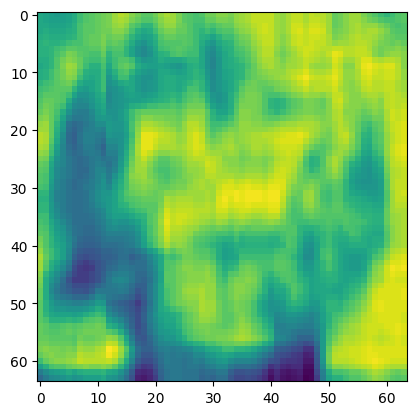

In [37]:
plt.imshow(images[0][0])

In [38]:
for images in proliv_loader:
    break

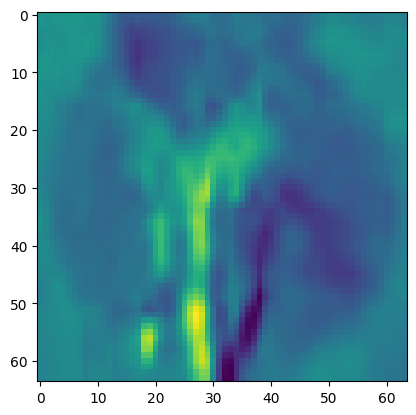

In [39]:
plt.imshow(images[0][0])

In [40]:
for images, labels in test_loader:
    break

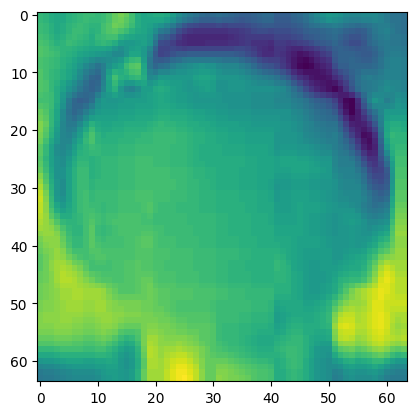

In [41]:
plt.imshow(images[labels==1][0][0])

# Model

## Simple autoencoder

### Encoder

In [42]:
class GatedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias=True):
        super(GatedConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias)
        self.gate_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.conv(x) * self.sigmoid(self.gate_conv(x))

In [43]:
class GatedEncoder(nn.Module):
    def __init__(self):
        super(GatedEncoder, self).__init__()
        self.encoder = nn.Sequential(
            GatedConv2d(1, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            
            GatedConv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
        )

    def forward(self, x):
        return self.encoder(x)

In [59]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(16, 1, 2, stride=2),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

In [60]:
# encoder = GatedEncoder()
encoder = Encoder()
decoder = Decoder()
z = encoder(images)
print(z.shape)
out = decoder(z)
print(out.shape)
assert out.shape == images.shape

torch.Size([64, 32, 16, 16])
torch.Size([64, 1, 64, 64])


In [61]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Training loop

In [62]:
class CalculateThresholdCallback(Callback):
    def __init__(self, every_n_epochs, val_loader, proliv_loader):
        self.every_n_epochs = every_n_epochs
        self.val_loader = val_loader
        self.proliv_loader = proliv_loader
        
    def on_train_epoch_end(self, trainer, pl_module):
        if not trainer.current_epoch % self.every_n_epochs == 0:
            return

        mse_normal = self.calculate_mse_for_loader(pl_module.model, self.val_loader, pl_module.device)
        mse_anomaly = self.calculate_mse_for_loader(pl_module.model, self.proliv_loader, pl_module.device)

        labels = np.array([0] * len(mse_normal) + [1] * len(mse_anomaly))
        mse_values = np.concatenate([mse_normal, mse_anomaly])
        fpr, tpr, thresholds = roc_curve(labels, mse_values)
        roc_auc = auc(fpr, tpr)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        pl_module.log('roc_auc', roc_auc)
        pl_module.log('opt_thresh', optimal_threshold)
        pl_module.optimal_threshold = optimal_threshold

    @staticmethod
    def calculate_mse_for_loader(model, loader, device):
        mse_values = []
        model.eval()
        with torch.no_grad():
            for images in loader:
                images = images.to(device)
                outputs = model(images)
                mse = F.mse_loss(outputs, images, reduction='none').mean([1, 2, 3])
                mse_values.extend(mse.detach().cpu().numpy())
        model.train()
        return np.array(mse_values)

In [63]:
class TestAnomalyCallback(Callback):
    def __init__(self, every_n_epochs, test_loader):
        self.every_n_epochs = every_n_epochs
        self.test_loader = test_loader

    def on_train_epoch_end(self, trainer, pl_module):
        if not trainer.current_epoch % self.every_n_epochs == 0:
            return

        all_labels = []
        all_preds = []
        pl_module.model.eval()
        for images, labels in self.test_loader:
            with torch.no_grad():
                images = images.to(pl_module.device)
            outputs = pl_module(images)
            mse = F.mse_loss(outputs, images, reduction='none').mean([1, 2, 3])
            preds = mse > pl_module.optimal_threshold

            all_labels.extend(labels.detach().cpu().numpy())
            all_preds.extend(preds.detach().cpu().numpy())

        pl_module.model.train()
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        tpr = tp / (tp + fn)
        tnr = tn / (tn + fp)

        pl_module.log('metrics/tpr', tpr)
        pl_module.log('metrics/tnr', tnr)
        pl_module.log('metrics/mean', (tpr+tnr)/2)

In [64]:
class LModule(L.LightningModule):
    def __init__(self, model: nn.Module):
        super(LModule, self).__init__()
        self.model = model
        self.loss = nn.MSELoss()
        self.optimal_threshold = 0

    def forward(self, x):
        return self.model(x)

    def training_step(self, images, batch_idx):
        outputs = self.model(images)
        loss = self.loss(outputs, images)
        self.log('loss/train', loss)
        return loss

    def validation_step(self, images, batch_idx):
        outputs = self.model(images)
        loss = self.loss(outputs, images)
        
        self.log('loss/val', loss)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=3e-5)

In [53]:
every_n_epochs = 5

In [54]:
eval_callback = CalculateThresholdCallback(every_n_epochs=every_n_epochs, val_loader=val_loader, proliv_loader=proliv_loader)
test_callback = TestAnomalyCallback(every_n_epochs=every_n_epochs, test_loader=test_loader)

In [55]:
callbacks = [eval_callback, test_callback]

In [56]:
max_epochs = 10
log_every_n_steps = 100

In [65]:
model = Autoencoder(Encoder(), Decoder())

In [66]:
module = LModule(model)
trainer = L.Trainer(
    callbacks=callbacks,
    max_epochs=max_epochs,
    log_every_n_steps=log_every_n_steps,
    logger=TensorBoardLogger('../logs/hw1', f'baseline'),
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [67]:
trainer.fit(module, train_loader, val_dataloaders=val_loader)

Missing logger folder: ../logs/hw1/baseline

  | Name  | Type        | Params
--------------------------------------
0 | model | Autoencoder | 7.1 K 
1 | loss  | MSELoss     | 0     
--------------------------------------
7.1 K     Trainable params
0         Non-trainable params
7.1 K     Total params
0.028     Total estimated model params size (MB)


Sanity Checking: |                                         | 0/? [00:00<?, ?it/s]

/Users/timur/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/timur/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                | 0/? [00:00<?, ?it/s]

Validation: |                                              | 0/? [00:00<?, ?it/s]

Validation: |                                              | 0/? [00:00<?, ?it/s]

Validation: |                                              | 0/? [00:00<?, ?it/s]

Validation: |                                              | 0/? [00:00<?, ?it/s]

Validation: |                                              | 0/? [00:00<?, ?it/s]

Validation: |                                              | 0/? [00:00<?, ?it/s]

/Users/timur/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [68]:
model.to('cpu')
model.eval()
print()

In [69]:
mse_normal = []
for images in val_loader:
    with torch.inference_mode():
        out = model(images)
        mse = F.mse_loss(out, images, reduction='none').mean([1, 2, 3])
    mse_normal.extend(mse.detach().cpu().numpy())
mse_normal = np.array(mse_normal)

In [70]:
mse_anomaly = []
for images in proliv_loader:
    with torch.inference_mode():
        out = model(images)
        mse = F.mse_loss(out, images, reduction='none').mean([1, 2, 3])
    mse_anomaly.extend(mse.detach().cpu().numpy())
mse_anomaly = np.array(mse_anomaly)

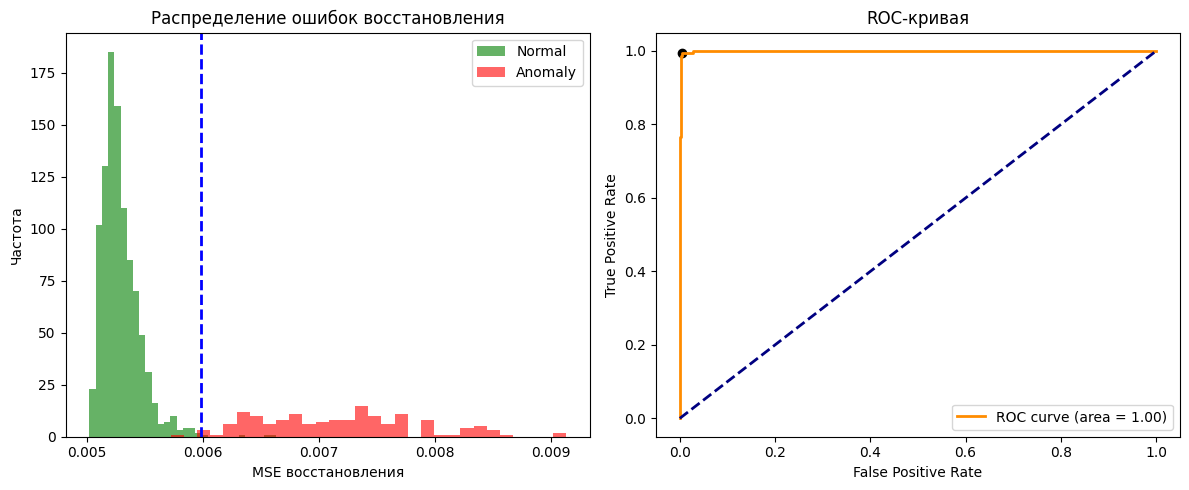

In [71]:
labels = np.array([0] * len(mse_normal) + [1] * len(mse_anomaly))
mse_values = np.concatenate([mse_normal, mse_anomaly])
fpr, tpr, thresholds = roc_curve(labels, mse_values)
roc_auc = auc(fpr, tpr)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(mse_normal, bins=30, alpha=0.6, color='g', label='Normal')
plt.hist(mse_anomaly, bins=30, alpha=0.6, color='r', label='Anomaly')
plt.axvline(optimal_threshold, color='b', linestyle='dashed', linewidth=2)
plt.title('Распределение ошибок восстановления')
plt.xlabel('MSE восстановления')
plt.ylabel('Частота')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='black')
plt.title('ROC-кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.tight_layout()
plt.show()

In [72]:
optimal_threshold

0.0059827343

In [78]:
test_root = '../data/hw_1/dataset/test/imgs'

In [80]:
test_fnames = []
gt_labels = []
with open('../data/hw_1/dataset/test/test_annotation.txt', 'r') as f:
    for line in f.readlines():
        fname, label = line.split()
        test_fnames.append(fname)
        gt_labels.append(int(label))

In [81]:
gt_labels = np.array(gt_labels)

In [83]:
pred_errors = []
for fname in test_fnames:
    img = Image.open(f"{test_root}/{fname}").convert('L')
    tensor = val_transforms(img)
    with torch.inference_mode():
        out = model(tensor.unsqueeze(0))
        mse = F.mse_loss(out.squeeze(0), tensor)
        pred_errors.append(mse.item())

In [84]:
pred_errors = np.array(pred_errors)

In [85]:
pred_labels = pred_errors > optimal_threshold

In [86]:
tn, fp, fn, tp = confusion_matrix(gt_labels, pred_labels).ravel()

# Расчет TPR и TNR
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"True Negative Rate (TNR): {tnr:.4f}")

True Positive Rate (TPR): 0.8062
True Negative Rate (TNR): 0.9195


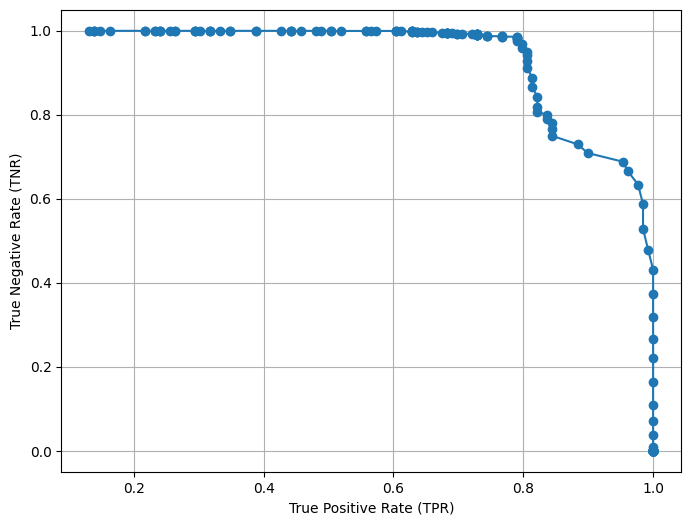

In [87]:
thresholds = np.linspace(optimal_threshold * 0.5, optimal_threshold * 1.5, 200)

tpr_list = []
tnr_list = []

for threshold in thresholds:
    pred_labels = pred_errors > threshold
    tn, fp, fn, tp = confusion_matrix(gt_labels, pred_labels).ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    tpr_list.append(tpr)
    tnr_list.append(tnr)

plt.figure(figsize=(8, 6))
plt.plot(tpr_list, tnr_list, marker='o')
plt.xlabel('True Positive Rate (TPR)')
plt.ylabel('True Negative Rate (TNR)')
plt.grid(True)
plt.show()

### артефакты связаны с недообучением, однако, при большем кол-ве эпох или при большей глубине модель не может достичь метрик выше 0.85

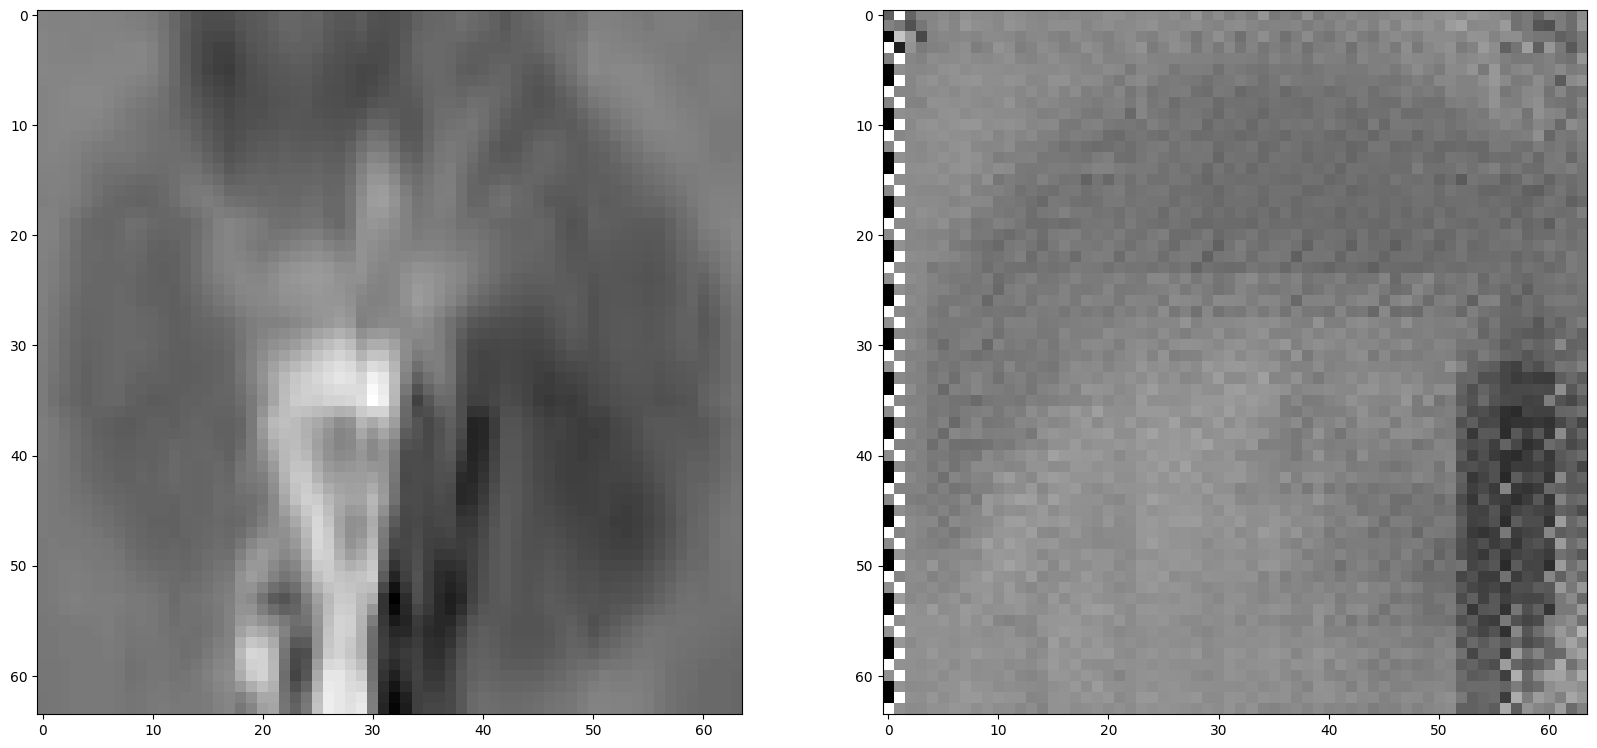

In [91]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 40))

axes[0].imshow(images.detach().cpu().numpy()[0][0], cmap='gray')
axes[1].imshow(out.detach().cpu().numpy()[0][0], cmap='gray')